In [ ]:
Import Libraries, Load Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
destinations_df = pd.read_excel("/Users/aliachern/Documents/FYP/Destinations.xlsx")
reviews_df = pd.read_excel("/Users/aliachern/Documents/FYP/User_Reviews.xlsx")
userhistory_df = pd.read_excel("/Users/aliachern/Documents/FYP/User_History.xlsx")
users_df = pd.read_excel("/Users/aliachern/Documents/FYP/Users.xlsx")

In [59]:
destinations_df.head()

,destination_id,name,state,category,description,avg_rating
0,1,Petronas Twin Towers,Kuala Lumpur,city,Iconic twin skyscrapers with a skybridge and o...,4.7
1,2,Batu Caves,Kuala Lumpur,city,Limestone hill with Hindu temple and large sta...,4.6
2,3,KL Tower,Kuala Lumpur,city,Tall tower offering panoramic views of Kuala L...,4.5
3,4,Merdeka Square,Kuala Lumpur,historical,Historic square commemorating Malaysian indepe...,4.4
4,5,Sultan Abdul Samad Building,Kuala Lumpur,historical,Colonial-era government building with Moorish ...,4.3


In [61]:
reviews_df.head()

,review_id,destination_id,user_id,ratings,review_comments
0,R0001,295,U0056,4,Music half general still doctor talk well pass...
1,R0002,242,U0024,4,Vote television site population staff letter i...
2,R0003,354,U0060,4,Future manage commercial face person surface c...
3,R0004,282,U0010,1,Whether artist establish daughter decide reduc...
4,R0005,387,U0060,2,Risk significant follow executive once among u...


In [63]:
userhistory_df.head()

,history_id,user_id,destination_id,visit_date,experience_ratings
0,H0001,U0056,91,2024-06-28,5
1,H0002,U0022,106,2024-10-26,2
2,H0003,U0015,233,2025-01-22,5
3,H0004,U0010,210,2024-04-16,3
4,H0005,U0041,96,2024-05-14,4


In [65]:
users_df.head()

,user_id,name,email,category_preferences,state_chosen,number_of_pax
0,U0001,Jennifer Briggs,davidcox@hotmail.com,nature,Perlis,4
1,U0002,Sarah Hernandez,lmora@coleman.com,beach,Selangor,4
2,U0003,Jeanne Jones,hensleyjames@hotmail.com,beach,Penang,5
3,U0004,Jenna Bates,jacqueline28@rodriguez.com,beach,Kelantan,5
4,U0005,Logan Chen,mandymoore@hotmail.com,adventure,Negeri Sembilan,3


In [9]:
# Normalize column names for merging
reviews_df.rename(columns={"destination ID": "destination_id", "User ID": "user_id"}, inplace=True)
userhistory_df.rename(columns={"destination ID": "destination_id", "user ID": "user_id"}, inplace=True)
users_df.rename(columns={"user ID": "user_id"}, inplace=True)

In [13]:
print("Reviews destination IDs:", reviews_df['destination_id'].unique()[:5])
print("Destinations IDs:", destinations_df['destination_id'].unique()[:5])

print("Reviews user IDs:", reviews_df['user_id'].unique()[:5])
print("User history user IDs:", userhistory_df['user_id'].unique()[:5])
print("Users user IDs:", users_df['user_id'].unique()[:5])


Reviews destination IDs: [295 242 354 282 387]
Destinations IDs: [1 2 3 4 5]
Reviews user IDs: ['U0056' 'U0024' 'U0060' 'U0010' 'U0008']
User history user IDs: ['U0056' 'U0022' 'U0015' 'U0010' 'U0041']
Users user IDs: ['U0001' 'U0002' 'U0003' 'U0004' 'U0005']


In [15]:
# Ensure all IDs are strings
reviews_df['destination_id'] = reviews_df['destination_id'].astype(str)
reviews_df['user_id'] = reviews_df['user_id'].astype(str)
destinations_df['destination_id'] = destinations_df['destination_id'].astype(str)
userhistory_df['destination_id'] = userhistory_df['destination_id'].astype(str)
userhistory_df['user_id'] = userhistory_df['user_id'].astype(str)
users_df['user_id'] = users_df['user_id'].astype(str)

In [17]:
# Step 1: Check overlap between reviews and destinations
print("Matching destination IDs:", len(set(reviews_df['destination_id']) & set(destinations_df['destination_id'])))

# Step 2: Check overlap between result and user history
print("Matching user IDs:", len(set(reviews_df['user_id']) & set(userhistory_df['user_id'])))
print("Matching destination IDs (history vs reviews):", len(set(userhistory_df['destination_id']) & set(reviews_df['destination_id'])))

# Step 3: Check overlap with users
print("Matching users in final merge:", len(set(userhistory_df['user_id']) & set(users_df['user_id'])))

Matching destination IDs: 91
Matching user IDs: 43
Matching destination IDs (history vs reviews): 14
Matching users in final merge: 58


In [19]:
merged_test = pd.merge(reviews_df, destinations_df, on='destination_id', how='outer', indicator=True)
print(merged_test['_merge'].value_counts())

_merge
right_only    384
both          100
left_only       0
Name: count, dtype: int64


In [21]:
# Ensure string types
for df in [reviews_df, destinations_df, userhistory_df, users_df]:
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    if 'user_id' in df.columns:
        df['user_id'] = df['user_id'].astype(str)
    if 'destination_id' in df.columns:
        df['destination_id'] = df['destination_id'].astype(str)

# Merge step-by-step
reviews_dest = pd.merge(reviews_df, destinations_df, on='destination_id', how='inner')
merged_temp = pd.merge(reviews_dest, userhistory_df, on='user_id', how='inner')
df = pd.merge(merged_temp, users_df, on='user_id', how='inner')

print("Merged DataFrame shape:", df.shape)
df.head()


Merged DataFrame shape: (104, 19)


,review_id,destination_id_x,user_id,ratings,review_comments,name_x,state,category,description,avg_rating,history_id,destination_id_y,visit_date,experience_ratings,name_y,email,category_preferences,state_chosen,number_of_pax
0,R0001,295,U0056,4,Music half general still doctor talk well pass...,Pantai Melawi,Kelantan,beach,Traditional fishing beach with colorful boats.,3.8,H0001,91,2024-06-28,5,Valerie Wells,ramirezjeffrey@kelley-smith.info,beach,Johor,5
1,R0002,242,U0024,4,Vote television site population staff letter i...,D'Suasane Ibai,Terengganu,city,Floating restaurant complex serving local cuis...,4.0,H0011,428,2023-11-21,3,Ronald Cruz,frodgers@hotmail.com,adventure,Negeri Sembilan,1
2,R0002,242,U0024,4,Vote television site population staff letter i...,D'Suasane Ibai,Terengganu,city,Floating restaurant complex serving local cuis...,4.0,H0018,419,2023-07-24,2,Ronald Cruz,frodgers@hotmail.com,adventure,Negeri Sembilan,1
3,R0003,354,U0060,4,Future manage commercial face person surface c...,Tunku Abdul Rahman Marine Park,Sabah,nature,Five beautiful islands near KK with excellent ...,4.6,H0033,45,2023-10-23,3,Tracie Mann,johnsonmichele@fox.com,nature,Kuala Lumpur,3
4,R0003,354,U0060,4,Future manage commercial face person surface c...,Tunku Abdul Rahman Marine Park,Sabah,nature,Five beautiful islands near KK with excellent ...,4.6,H0039,375,2025-05-05,2,Tracie Mann,johnsonmichele@fox.com,nature,Kuala Lumpur,3


In [ ]:
Data Preprocessing

In [67]:
df.drop_duplicates(inplace=True)
df.shape

(104, 20)

In [69]:
df.to_csv("final_df.csv",index=False)

In [ ]:
Data Visualization

/var/folders/3s/_lykbhcn7s576dy29mq1lcbc0000gn/T/ipykernel_67674/2227755271.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_rating', y='name', data=top_dest, palette='viridis')


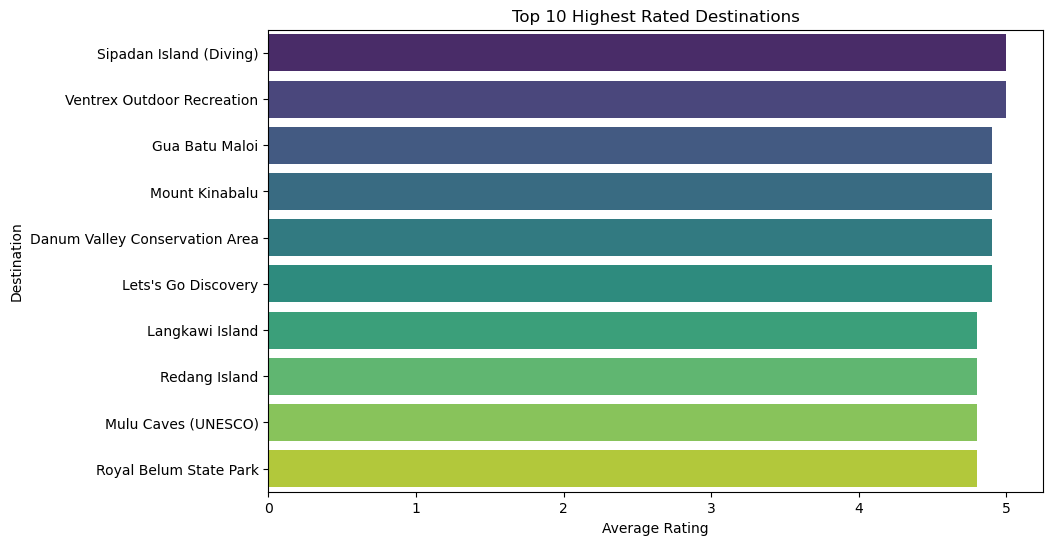

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 🔥 Destination Popularity by Average Rating
plt.figure(figsize=(10, 6))
top_dest = destinations_df.sort_values(by='avg_rating', ascending=False).head(10)
sns.barplot(x='avg_rating', y='name', data=top_dest, palette='viridis')
plt.title('Top 10 Highest Rated Destinations')
plt.xlabel('Average Rating')
plt.ylabel('Destination')
plt.show()

/var/folders/3s/_lykbhcn7s576dy29mq1lcbc0000gn/T/ipykernel_67674/3846268021.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='category', data=destinations_df, order=destinations_df['category'].value_counts().index, palette='coolwarm')


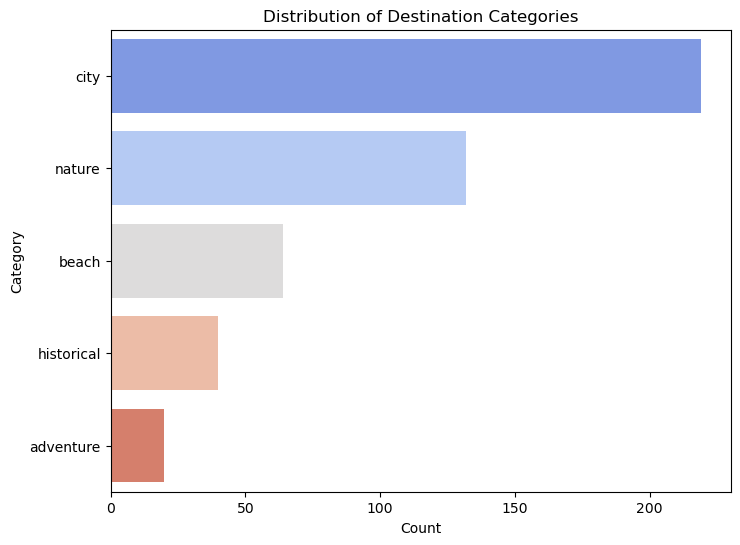

In [25]:
# 2. 🏞 Destination Types (Category) Distribution
plt.figure(figsize=(8, 6))
sns.countplot(y='category', data=destinations_df, order=destinations_df['category'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Destination Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

/var/folders/3s/_lykbhcn7s576dy29mq1lcbc0000gn/T/ipykernel_67674/2205055773.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='state', data=destinations_df, order=destinations_df['state'].value_counts().index, palette='mako')


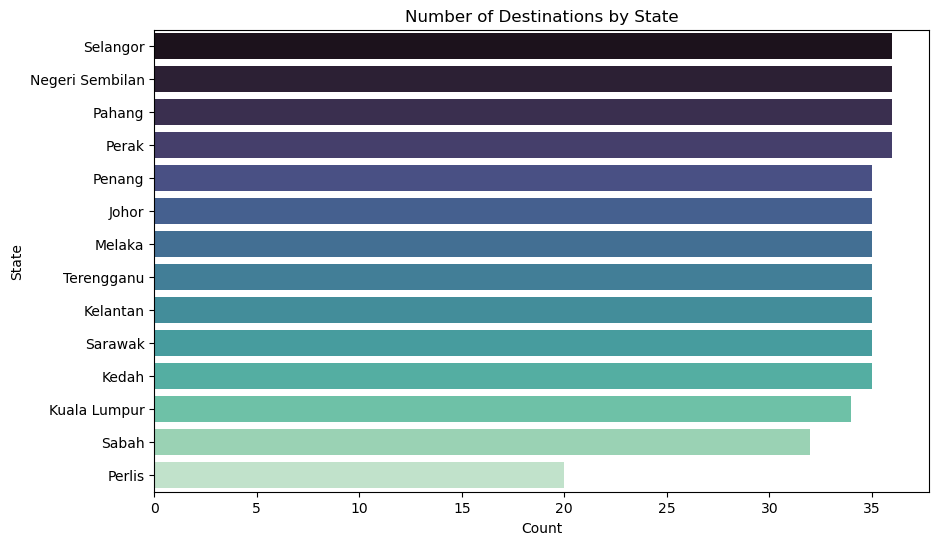

In [73]:
# 3. 📍 Destinations per State
plt.figure(figsize=(10, 6))
sns.countplot(y='state', data=destinations_df, order=destinations_df['state'].value_counts().index, palette='mako')
plt.title('Number of Destinations by State')
plt.xlabel('Count')
plt.ylabel('State')
plt.show()

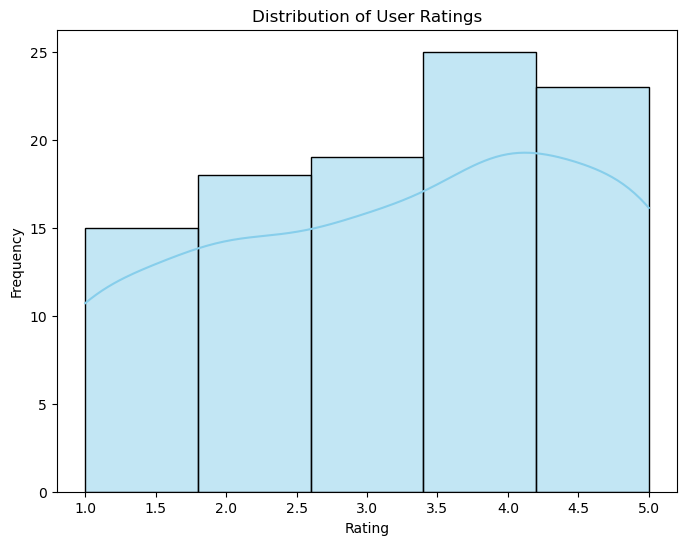

In [75]:
# 4. 🌟 Ratings Distribution from User Reviews
plt.figure(figsize=(8, 6))
sns.histplot(reviews_df['ratings'], bins=5, kde=True, color='skyblue')
plt.title('Distribution of User Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [ ]:
Content-Based Recommendation Model

In [89]:
# Step 0: Work from the clean destination DataFrame
destinations_df['features'] = (
    destinations_df['category'].fillna('') + ' ' +
    destinations_df['state'].fillna('')
)

# Step 1: Apply TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
destination_features = vectorizer.fit_transform(destinations_df['features'])

# Step 2: Compute Cosine Similarity between unique destinations
cosine_sim = cosine_similarity(destination_features, destination_features)

# Step 3: Confirm dimensions
print("Cosine Similarity Matrix Shape:", cosine_sim.shape)

Cosine Similarity Matrix Shape: (475, 475)


In [91]:
def recommend_destinations(user_id, userhistory_df, destination_lookup_df, cosine_sim):
    """
    Recommend top 5 destinations based on content similarity.

    Parameters:
    - user_id: str, like 'U0010'
    - userhistory_df: user_id + destination_id
    - destination_lookup_df: the exact DataFrame used to build cosine_sim
    - cosine_sim: cosine similarity matrix (N x N where N = len(destination_lookup_df))

    Returns:
    - pd.DataFrame of top 5 recommended destinations
    """
    user_id = str(user_id)
    visited_ids = userhistory_df[userhistory_df['user_id'] == user_id]['destination_id'].astype(str).tolist()
    all_ids = destination_lookup_df['destination_id'].astype(str).tolist()

    # Only use destinations that exist in the lookup used to build cosine matrix
    visited_indices = [i for i, did in enumerate(all_ids) if did in visited_ids]

    if not visited_indices:
        print(f"⚠️ User {user_id} has no matching visit history in the destination list.")
        return pd.DataFrame(columns=['destination_id', 'name', 'state', 'category', 'avg_rating'])

    # Compute average similarity vector
    sim_scores = cosine_sim[visited_indices].mean(axis=0)
    ranked_indices = sim_scores.argsort()[::-1]

    recommendations = []
    for idx in ranked_indices:
        did = all_ids[idx]
        if did not in visited_ids:
            dest_row = destination_lookup_df.iloc[idx][['destination_id', 'name', 'state', 'category', 'avg_rating']]
            recommendations.append(dest_row)
        if len(recommendations) == 5:
            break

    return pd.DataFrame(recommendations)

In [93]:
# destination_lookup_df must match what you used to build cosine_sim
recommended = recommend_destinations('U0010', userhistory_df, destinations_df, cosine_sim)
print(recommended)

    destination_id                  name       state category  avg_rating
232            233         Pantai Pandak  Terengganu    beach         3.9
216            217      Batu Buruk Beach  Terengganu    beach         4.2
226            227  Pantai Bukit Keluang  Terengganu    beach         4.3
211            212          Kapas Island  Terengganu    beach         4.4
210            211    Perhentian Islands  Terengganu    beach         4.7


In [95]:
# destination_lookup_df must match what you used to build cosine_sim
recommended = recommend_destinations('U0024', userhistory_df, destinations_df, cosine_sim)
print(recommended)

    destination_id                 name  state category  avg_rating
440            441         Lubuk Pedati  Kedah   nature         4.0
448            449   Taman Burung Kulim  Kedah   nature         3.9
447            448        Bukit Kodiang  Kedah   nature         3.8
434            435       Darulaman Park  Kedah   nature         3.9
446            447  Lata Bayu Waterfall  Kedah   nature         4.2


In [ ]:
Collaborative Filtering

In [97]:
# Step 1: Create user-item matrix (rows = users, columns = destinations)
user_item_matrix = userhistory_df.pivot(
    index='user_id', 
    columns='destination_id', 
    values='experience_ratings'
)

# Step 2: Fill missing values with 0 (unvisited/unrated destinations)
user_item_matrix.fillna(0, inplace=True)

# Step 3: Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_matrix)

# Optional: Wrap as DataFrame for easy lookup
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_matrix.index, columns=user_item_matrix.index)

# Confirm shape
print("User similarity matrix shape:", user_similarity_df.shape)

User similarity matrix shape: (58, 58)


In [99]:
def collaborative_recommend(user_id, user_similarity_df, user_item_matrix, destinations_df):
    """
    Recommends destinations based on user-user collaborative filtering.

    Args:
    - user_id: ID of the user (string, e.g., 'U0010')
    - user_similarity_df: DataFrame with cosine similarity between users
    - user_item_matrix: pivoted user-destination matrix with ratings
    - destinations_df: DataFrame with destination info

    Returns:
    - DataFrame of top 5 recommended destinations
    """
    user_id = str(user_id)

    if user_id not in user_similarity_df.index:
        print(f"❌ User ID '{user_id}' not found in similarity matrix.")
        return pd.DataFrame()

    # Step 1: Get top 5 most similar users (excluding self)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).drop(user_id).head(5)

    # Step 2: Average the destination ratings from similar users
    similar_user_ratings = user_item_matrix.loc[similar_users.index].mean(axis=0)

    # Step 3: Filter out destinations the user has already rated
    user_rated = user_item_matrix.loc[user_id]
    unrated = user_rated[user_rated == 0]

    # Step 4: Recommend top destinations among unrated ones
    recommendations = similar_user_ratings[unrated.index].sort_values(ascending=False).head(5).index

    # Step 5: Match destination details
    recommended_df = destinations_df[
        destinations_df['destination_id'].astype(str).isin(recommendations.astype(str))
    ][['destination_id', 'name', 'state', 'category', 'avg_rating']]

    return recommended_df

In [101]:
collaborative_recommendations = collaborative_recommend('U0010', user_similarity_df, user_item_matrix, destinations_df)
print(collaborative_recommendations)

    destination_id                         name            state category  \
90              91  Dhammikarama Burmese Temple           Penang     city   
199            200     Teluk Kemang Observatory  Negeri Sembilan     city   
242            243    Kampung Budaya Terengganu       Terengganu     city   
320            321               Pangkor Island            Perak    beach   
444            445               Pulau Songsong            Kedah    beach   

     avg_rating  
90          4.2  
199         3.9  
242         3.9  
320         4.5  
444         4.0  


In [103]:
collaborative_recommendations = collaborative_recommend('U0056', user_similarity_df, user_item_matrix, destinations_df)
print(collaborative_recommendations)

    destination_id                          name            state    category  \
135            136          Adventure Theme Park            Johor      nature   
179            180  Negeri Sembilan State Museum  Negeri Sembilan  historical   
242            243     Kampung Budaya Terengganu       Terengganu        city   
423            424                Pantai Merdeka            Kedah       beach   
444            445                Pulau Songsong            Kedah       beach   

     avg_rating  
135         3.8  
179         3.9  
242         3.9  
423         3.9  
444         4.0  


In [ ]:
User input feature base recommendation

In [121]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load and preprocess the data
data = pd.read_csv('final_df.csv')

# Rename column for consistency
df.rename(columns={'name_x': 'name'}, inplace=True)

# Select features and target
features = ['name', 'state', 'category', 'category_preferences', 'number_of_pax']
target = 'avg_rating'

# Encode categorical features
label_encoders = {}
for col in features:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Prepare data
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate model
y_pred = model.predict(X_test)
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R² Score: {r2_score(y_test, y_pred):.2f}")

Mean Squared Error: 0.03
R² Score: 0.78


In [143]:
import pickle

pickle.dump(model, open("model.pkl",'wb'))
pickle.dump(label_encoders, open("label_encoders.pkl",'wb'))